In [1]:
!pip install kagglehub scikit-fuzzy opencv-python scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.2 MB/s eta 0:00:00


In [2]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from glob import glob
from sklearn.metrics import silhouette_score

In [3]:
dataset_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Dataset Path =", dataset_path)

Using Colab cache for faster access to the 'blood-cells' dataset.
Dataset Path = /kaggle/input/blood-cells


In [4]:
img_dir_list = glob(dataset_path + "/**/images", recursive=True)

if len(img_dir_list) == 0:
    raise Exception("Image folder not found")

root_image_folder = img_dir_list[0]
print("Image root folder =", os.listdir(root_image_folder))

Image root folder = ['TEST_SIMPLE', 'TEST', 'TRAIN']


In [5]:
train_folder_path = os.path.join(root_image_folder, "TRAIN")

print("Classes inside Train = ")
print(os.listdir(train_folder_path))

selected_class = os.listdir(train_folder_path)[0]
selected_class_folder = os.path.join(train_folder_path, selected_class)

print("\nUsing class =", selected_class)

Classes inside Train = 
['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']

Using class = MONOCYTE


In [6]:
img_file_list = glob(selected_class_folder + "/*.jpeg") + \
                glob(selected_class_folder + "/*.jpg") + \
                glob(selected_class_folder + "/*.png")

print("Total no of images = ", len(img_file_list))

loaded_images = []
for img_path in img_file_list[:5]:
    temp_img = cv2.imread(img_path)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    loaded_images.append(temp_img)

print("No of loaded images = ", len(loaded_images))

Total no of images =  2478
No of loaded images =  5


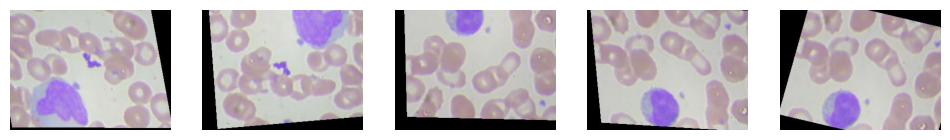

In [7]:
plt.figure(figsize=(12,4))
for idx, image_item in enumerate(loaded_images):
    plt.subplot(1, len(loaded_images), idx+1)
    plt.imshow(image_item)
    plt.axis("off")
plt.show()

In [8]:
def kmeans_segmentation(input_image, k=3):
    lab_img = cv2.cvtColor(input_image, cv2.COLOR_RGB2LAB)
    height, width, channels = lab_img.shape
    pixel_array = lab_img.reshape((-1,3)).astype(np.float32)

    kmeans_model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans_model.fit_predict(pixel_array)

    return cluster_labels.reshape(height, width), cluster_labels

In [9]:
def fuzzy_segmentation(input_image, c=3):
    lab_img = cv2.cvtColor(input_image, cv2.COLOR_RGB2LAB)
    height, width, ch = lab_img.shape

    pixel_array = lab_img.reshape((-1,3)).astype(np.float32)
    pixel_array_T = pixel_array.T

    centers, membership, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixel_array_T, c=c, m=2, error=0.005, maxiter=1000
    )

    fuzzy_labels = np.argmax(membership, axis=0)
    return fuzzy_labels.reshape(height, width), fuzzy_labels

In [10]:
def extract_dark_cluster(segmented_map, original_image):
    lab_img = cv2.cvtColor(original_image, cv2.COLOR_RGB2LAB)
    pixel_values = lab_img.reshape((-1,3))

    mean_values = []
    for cluster_idx in range(3):
        mean_values.append(np.mean(pixel_values[segmented_map.reshape(-1) == cluster_idx]))

    nucleus_cluster_index = np.argmin(mean_values)
    nucleus_mask = (segmented_map == nucleus_cluster_index).astype(np.uint8) * 255
    return nucleus_mask

In [11]:
def nucleus_metrics(mask_image):
    nucleus_area = np.sum(mask_image > 0)
    nucleus_percent = nucleus_area / mask_image.size

    edge_map = cv2.Canny(mask_image, 50, 150)
    boundary_pixels = np.sum(edge_map > 0)

    nucleus_compactness = (boundary_pixels**2) / (nucleus_area + 1e-6)

    return nucleus_area, nucleus_percent, boundary_pixels, nucleus_compactness


Image 1
KMeans Silhouette =  0.6020444194480034
Fuzzy Silhouette =  0.6037049673849388


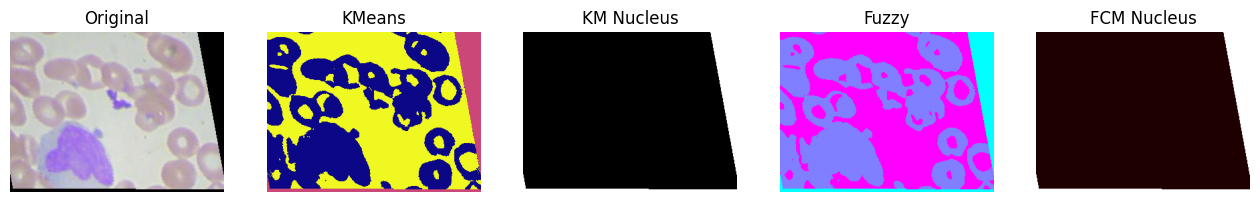


Image 2
KMeans Silhouette =  0.6347441816453582
Fuzzy Silhouette =  0.6362190650803764


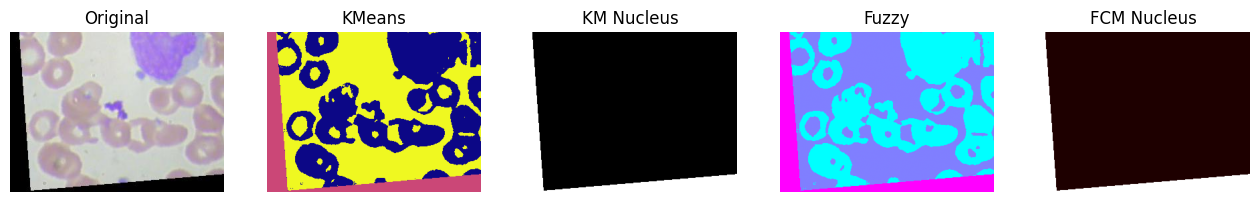


Image 3
KMeans Silhouette =  0.685740561333517
Fuzzy Silhouette =  0.6861977883449345


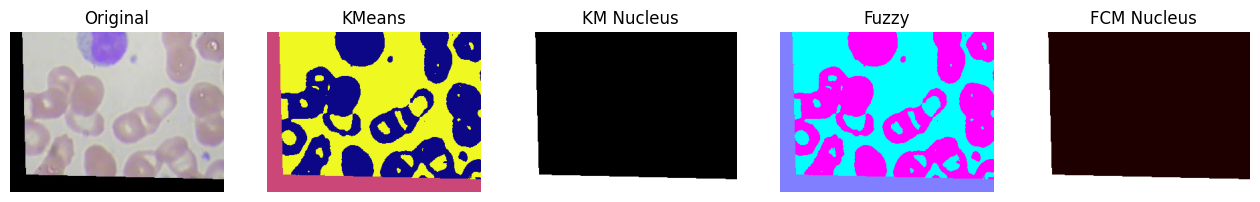

In [13]:
for index, image_data in enumerate(loaded_images[:3]):

    seg_kmeans, labels_kmeans = kmeans_segmentation(image_data)
    seg_fuzzy, labels_fuzzy = fuzzy_segmentation(image_data)

    mask_kmeans = extract_dark_cluster(seg_kmeans, image_data)
    mask_fuzzy = extract_dark_cluster(seg_fuzzy, image_data)

    lab_img = cv2.cvtColor(image_data, cv2.COLOR_RGB2LAB)
    pixel_matrix = lab_img.reshape((-1,3))

    silhouette_kmeans = silhouette_score(pixel_matrix, labels_kmeans)
    silhouette_fuzzy = silhouette_score(pixel_matrix, labels_fuzzy)

    km_area, km_pct, km_bound, km_comp = nucleus_metrics(mask_kmeans)
    f_area, f_pct, f_bound, f_comp = nucleus_metrics(mask_fuzzy)

    print("\n==============================")
    print("Image", index + 1)

    print("KMeans Silhouette = ", silhouette_kmeans)
    print("Fuzzy Silhouette = ", silhouette_fuzzy)

    plt.figure(figsize=(16,4))

    plt.subplot(1,5,1); plt.imshow(image_data); plt.title("Original"); plt.axis("off")
    plt.subplot(1,5,2); plt.imshow(seg_kmeans, cmap="plasma"); plt.title("KMeans"); plt.axis("off")
    plt.subplot(1,5,3); plt.imshow(mask_kmeans, cmap="bone"); plt.title("KM Nucleus"); plt.axis("off")
    plt.subplot(1,5,4); plt.imshow(seg_fuzzy, cmap="cool"); plt.title("Fuzzy"); plt.axis("off")
    plt.subplot(1,5,5); plt.imshow(mask_fuzzy, cmap="pink"); plt.title("FCM Nucleus"); plt.axis("off")

    plt.show()